In [181]:
%matplotlib inline
import numpy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Генерация датасета

sgm - дисперсия гауссова распределения
n - количество точек

In [169]:
sgm=0.5
n=10000
red_dots = numpy.random.multivariate_normal([3, 5, 9], [[sgm,0,0], [0, sgm, 0], [0, 0, sgm]], n)
blue_dots = numpy.random.multivariate_normal([4, 6, 9], [[sgm,0,0], [0, sgm, 0], [0, 0, sgm]], n)
red_dots=numpy.insert(red_dots, 3, 0, axis=1)
blue_dots=numpy.insert(blue_dots, 3, 1, axis=1)
data = numpy.concatenate((red_dots, blue_dots))
numpy.random.shuffle(data)

# sklearn

In [178]:
lr=LogisticRegression(solver='lbfgs', C=1e-3, tol=1e-10, max_iter=100000)
lr.fit(data[:, 0:3], data[:, 3])
print('v = ', lr.coef_)

scores = cross_val_score(lr, data[:, 0:3], data[:, 3], cv = 5, scoring='roc_auc')
print('scores=', scores)
print('mean score = ', scores.mean())

v =  [[ 1.10116667  1.07848652 -0.01121585]]
scores= [ 0.921503    0.921072    0.92748675  0.922953    0.92452375]
mean score =  0.9235077


In [182]:
clf=RandomForestClassifier()

scores = cross_val_score(clf, data[:, 0:3], data[:, 3], cv = 5, scoring='roc_auc')
print('scores=', scores)
print('mean score = ', scores.mean())

scores= [ 0.88945488  0.89032637  0.89972438  0.897261    0.89136275]
mean score =  0.893625875


# Трёхмерный рисунок

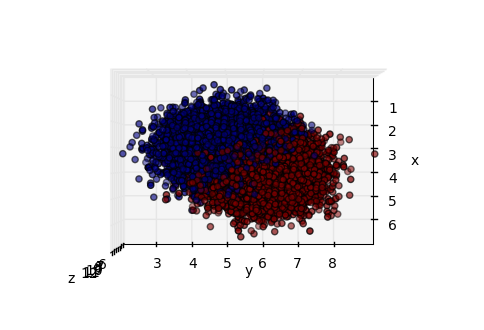

In [172]:
ax=plt.axes(projection='3d')
ax.view_init(90,0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
x=data[:, 0]
y=data[:, 1]
z=data[:, 2]
dx=max(x)-min(x)
dy=max(y)-min(y)
dz=max(z)-min(z)
dcommon = max(dx, dy, dz)
mx = (max(x)+min(x))/2
my = (max(y)+min(y))/2
mz = (max(z)+min(z))/2
ax.set_xlim3d((mx-dcommon/2,mx+dcommon/2))
ax.set_ylim3d((my-dcommon/2,my+dcommon/2))
ax.set_zlim3d((mz-dcommon/2,mz+dcommon/2))
ax.scatter(x,y,z, c=data[:, 3])
plt.show()

In [173]:
w1=numpy.array(lr.coef_[0])
w2=numpy.array([1, 0, 0])
w = w1

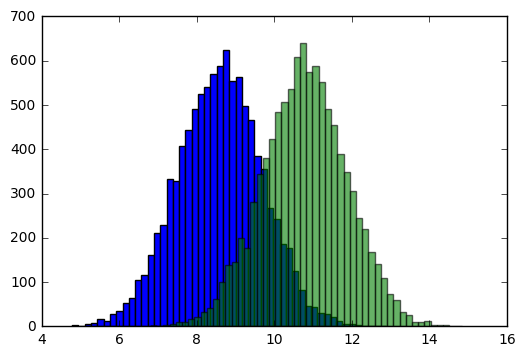

In [174]:
n=data.shape[0]
projections=numpy.zeros((n,2))
projections[:,1]=data[:,3]
for t in range(n):
    projections[t,0] = w.dot(data[t,:3])

def make_proj(data, w):
    pr1=data[:,:3].dot(w)
    return numpy.stack((pr1,data[:,3]), axis=1)

prj=make_proj(data, w)
plt.hist(prj[prj[:, 1]<0.5][:, 0], 50)
plt.hist(prj[prj[:, 1]>0.5][:, 0], 50, alpha=0.6)
plt.show()

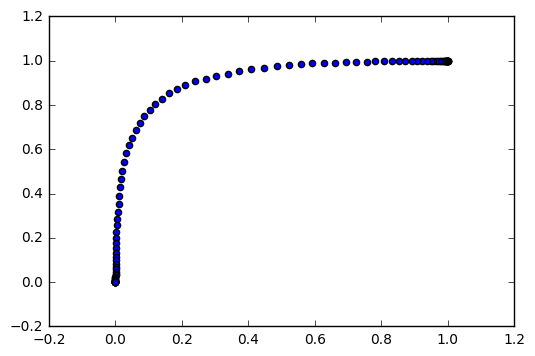

In [175]:
prj=make_proj(data, w)
x=[]
y=[]
for thresh in numpy.linspace(numpy.min(prj[:,0]), numpy.max(prj[:, 0]), 100):
    tp = 0
    fp = 0
    den_less = 0
    den_more = 0
    for t in range(n):
        guess = 0
        if prj[t, 0] > thresh:
            guess = 1
        if guess > 0.5 and prj[t, 1] > 0.5:
            tp += 1
        if guess > 0.5 and prj[t, 1] < 0.5:
            fp += 1
        if prj[t, 1] < 0.5:
            den_less += 1
        else:
            den_more += 1
    if den_more > 0 and den_less > 0:
        current_x = fp / den_less
        current_y = tp / den_more
        x.append(current_x)
        y.append(current_y)
plt.scatter(x,y)